## **Content, Collaborative, Hybrid Recommendation engine**

**Below is a simplified process for doing this:**
<br/>**1. Begin by cleaning the data.**
<br/>---In this dataset, there are dashes that would be good to remove. 
<br/>---Identify unique movies that have been rated.
<br/>---Remove users who haven’t at least rated 55 movies. This will help reduce data volume as well as improve the quality of data.
<br/>**2. Merge datasets**
<br/>---In this case, we’ll use both genres and tags. So, combine the two datasets for metadata. 
<br/>**3. Create vectors**
<br/>---Create vectors using TF-IDF. Term frequency-inverse document frequency (TF-IDF) is a technique that gives more importance to rare words and less importance to stop words such as prepositions etc. This helps improve recommendation accuracy.
<br/>**4. Perform dimension reduction**
<br/>---This dataset gives what we call a sparse matrix. Which means, out of the 3 lakh or so items, a user might have seen 100 movies. For the rest, the rating will be empty. So, perform singular value decomposition (SVD) for dimension reduction.
<br/>---This will identify variables that have the most variance. 
<br/>**5. Run algorithms for the target film**
<br/>---This can be content filtering, collaborative filtering or a hybrid one.

In [0]:
%scala
//<USER INPUT FILEPATH PARQUET OR CSV>

val filepath1= "abfss://.../mldata/MoviesDataRecommendation/ratings.csv"
var df1=spark.read.format("csv").option("header", "true").option("delimiter", ",").load(filepath1)
df1.createOrReplaceTempView("ratings")

val filepath2= "abfss://.../mldata/MoviesDataRecommendation/movies.csv"
var df2=spark.read.format("csv").option("header", "true").option("delimiter", ",").load(filepath2)
df2.createOrReplaceTempView("movies")

val filepath3= "abfss://.../mldata/MoviesDataRecommendation/tags.csv"
var df3=spark.read.format("csv").option("header", "true").option("delimiter", ",").load(filepath3)
df3.createOrReplaceTempView("tags")


filepath1: String = abfss://adlsstore@psinsightsadlsdev.dfs.core.windows.net/mldata/MoviesDataRecommendation/ratings.csv
df1: org.apache.spark.sql.DataFrame = [userId: string, movieId: string ... 2 more fields]
filepath2: String = abfss://adlsstore@psinsightsadlsdev.dfs.core.windows.net/mldata/MoviesDataRecommendation/movies.csv
df2: org.apache.spark.sql.DataFrame = [movieId: string, title: string ... 1 more field]
filepath3: String = abfss://adlsstore@psinsightsadlsdev.dfs.core.windows.net/mldata/MoviesDataRecommendation/tags.csv
df3: org.apache.spark.sql.DataFrame = [userId: string, movieId: string ... 2 more fields]

In [0]:
#Convert spark sql df to pyspark df

#For memory saving mode: consider only 5 movies and 2 such user records, also fill non rated movies in users 
movies= spark.sql("""select * from movies where movieid >=1 and movieid<=5""")
ratings= spark.sql("""with CTE_All as
(select distinct
R.Userid 
,M.movieId
from (select * from movies where movieid >=1 and movieid<=5) M 
CROSS JOIN (select * from ratings where userid in ('120092','13940','149463'))  R
)

--Get zero ratings for the movies not rated by users by coalescing.
,CTEUsers as
(select 
A.userid
,A.movieId
,COALESCE(R.rating,0) as rating
from CTE_All A
LEFT JOIN ratings R on R.userid=A.userid and R.movieId=A.movieId
)
select 
A.userId
,A.movieId
,A.rating
,M.title
,M.genres
from
CTEUsers A
LEFT JOIN movies M on M.movieId=A.movieId""")
tags= spark.sql("""select userId,movieId,tag from tags where movieid >=1 and movieid<=5 and userid in ('120092','13940','149463')""")

#dtype conversion-rating df
import pandas as pd
import numpy as np
from pyspark.sql.functions import col
cols_all=['userId'
,'movieId'
,'rating']
cols_string=[]
cols_int=['rating']
cols_bool=[]
cols_Float=[]
for col_name in cols_int:
    ratings = ratings.withColumn(col_name, col(col_name).cast('Int'))  
for col_name in cols_Float:
    ratings = ratings.withColumn(col_name, col(col_name).cast('float')) 
for col_name in cols_bool:
    ratings = ratings.withColumn(col_name, col(col_name).cast('bool')) 
    
movies  = movies.toPandas()
ratings = ratings.toPandas()
tags = tags.toPandas()

#persist for handy use
outdir = '/dbfs/FileStore/movies.csv'
movies.to_csv(outdir, index=False)
outdir = '/dbfs/FileStore/ratings.csv'
ratings.to_csv(outdir, index=False)
outdir = '/dbfs/FileStore/tags.csv'
tags.to_csv(outdir, index=False)
#input_dataframe = pd.read_csv("/dbfs/FileStore/Dataframe.csv", header='infer')

In [0]:
movies = pd.read_csv("/dbfs/FileStore/movies.csv", header='infer')
ratings = pd.read_csv("/dbfs/FileStore/ratings.csv", header='infer')
tags = pd.read_csv("/dbfs/FileStore/tags.csv", header='infer')

## Content Based Movie Data

In [0]:
movies['genres']=movies['genres'].str.replace('|',' ')
movies.head()

Out[21]:

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
tags.head()

Out[19]:

,userId,movieId,tag
0,13940,2,kid flick
1,13940,3,sequel fever
2,13940,5,sequel fever
3,120092,1,adventure
4,120092,1,animation


In [0]:
ratings.head()

Out[57]:

,userId,movieId,rating,title,genres
0,120092,1,5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,120092,2,3,Jumanji (1995),Adventure|Children|Fantasy
2,120092,3,0,Grumpier Old Men (1995),Comedy|Romance
3,120092,4,0,Waiting to Exhale (1995),Comedy|Drama|Romance
4,120092,5,0,Father of the Bride Part II (1995),Comedy


In [0]:
len(movies.movieId.unique())

Out[22]: 5

In [0]:
len(ratings[ratings['rating']>0].movieId.unique())

Out[24]: 4

In [0]:
#Merge movies with tags to get the Content for each movie
mixed= pd.merge(movies, tags, on='movieId', how='left')
mixed['tag']=mixed['tag'].fillna('NA')

#Get all tags in single row
mixed['tag'] = mixed[['movieId','title','genres','tag']].groupby(['movieId','title','genres'])['tag'].transform(lambda x: ' '.join(x))
mixed['metadata']=mixed['genres']+mixed['tag']
mixed=mixed[['movieId',	'title','metadata']]
final=mixed.drop_duplicates()
final



Out[66]:

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasyadv...
9,2,Jumanji (1995),Adventure Children Fantasykid flick animals bo...
21,3,Grumpier Old Men (1995),Comedy Romancesequel fever
22,4,Waiting to Exhale (1995),Comedy Drama RomanceNA
23,5,Father of the Bride Part II (1995),Comedysequel fever


In [0]:
final.loc[0,'metadata']

Out[68]: 'Adventure Animation Children Comedy Fantasyadventure animation buddy movie Disney friendship pixar Tom Hanks animation Tom Hanks'

In [0]:
#To get cosine similarities the Content (metadata) must be converted to vectors from string. Convert each Content (metadata) to vector. The vector will be sparse and very huge

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), index= final.index.to_list())
tfidf_df.shape

Out[73]: (5, 29)

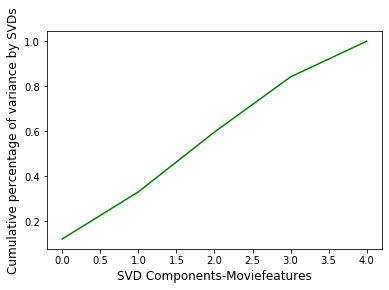

In [0]:
#Compress the huge sparse vector with SVD- each movie described by 29 components, reuce it to Top 6 as we can see 100 % of variance reflected by top 4 features
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as pt

svd= TruncatedSVD(n_components=6)
latent_matrix=svd.fit_transform(tfidf_df)
latent_df=pd.DataFrame(latent_matrix, index= final.title.to_list())

#Check the variance shown by the reduced/compressed vector. Ideally choose uptil the variance becomes steady and adding new components does not increases the variance more
explained=svd.explained_variance_ratio_.cumsum()
pt.plot(explained, color='green')
pt.xlabel('SVD Components-Moviefeatures',fontsize=12)
pt.ylabel('Cumulative percentage of variance by SVDs',fontsize=12)
pt.show()


latent_df shows Movies vs Movie Features(Content)

## Collaborative User Ratings

In [0]:
#Get user ratings and movies pivot table
ratings1= pd.merge(movies['movieId'],ratings, on='movieId', how='right')
ratings2=ratings1.pivot(index='movieId',columns='userId',values='rating').fillna(0) #to fill zeroes for the movies not seen/rated by users
ratings2.head()

Out[107]:

userId,13940,120092,149463
movieId,,,
1,4,5,3
2,2,3,3
3,1,0,0
4,0,0,0
5,1,0,0


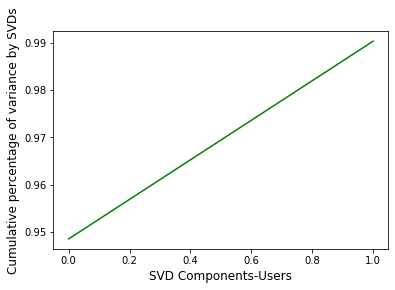

In [0]:
#Compress the huge sparse vector with SVD- each movie described by 29 components, reuce it to Top 6 as we can see 100 % of variance reflected by top 4 features
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as pt

svd= TruncatedSVD(n_components=2)
latent_matrix_ratings=svd.fit_transform(ratings2)
latent_df_ratings=pd.DataFrame(latent_matrix_ratings, index= final.title.to_list())

#Check the variance shown by the reduced/compressed vector. Ideally choose uptil the variance becomes steady and adding new components does not increases the variance more
explained=svd.explained_variance_ratio_.cumsum()
pt.plot(explained, color='green')
pt.xlabel('SVD Components-Users',fontsize=12)
pt.ylabel('Cumulative percentage of variance by SVDs',fontsize=12)
pt.show()


latent_df_ratings shows Movies vs Users(Collaborative)

## Recommending via Content based filtering v/s Collaborative filtering v/s Hybrid
latent_df_ratings shows Movies vs Users(Collaborative)
<br/>latent_df shows Movies vs Movie features(Content)

In [0]:
#Movie X MovieFeatures
latent_df.head()

Out[112]:

,0,1,2,3,4
Toy Story (1995),0.190557,0.702271,-0.000000e+00,0.684215,-0.048506
Jumanji (1995),0.031472,0.605246,-5.931295e-01,-0.529922,0.008188
Grumpier Old Men (1995),0.832895,-0.073838,-5.273559e-16,-0.026403,0.547847
Waiting to Exhale (1995),0.426428,0.327366,7.007217e-01,-0.389124,-0.261844
Father of the Bride Part II (1995),0.706592,-0.326878,-3.964675e-01,0.105039,-0.475036


In [0]:
#Movie X UserRatings
latent_df_ratings.head()

Out[111]:

,0,1
Toy Story (1995),7.052064,-0.392232
Jumanji (1995),4.602741,0.784465
Grumpier Old Men (1995),0.538354,-0.784465
Waiting to Exhale (1995),0.000000,0.000000
Father of the Bride Part II (1995),0.538354,-0.784465


In [0]:
#
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
a_content=np.array(latent_df.loc['Toy Story (1995)']).reshape(1,-1)
a_collab=np.array(latent_df_ratings.loc['Toy Story (1995)']).reshape(1,-1)

score_content= cosine_similarity(latent_df,a_content).reshape(-1)
score_collab= cosine_similarity(latent_df_ratings,a_collab).reshape(-1)
score_hybrid= ((score_content+score_collab)/2.0)

DictDf= {'Content':score_content , 'Collaborative':score_collab, 'Hybrid':score_hybrid }
similarity=pd.DataFrame(DictDf, index=latent_df.index)
similarity.sort_values('Hybrid',ascending=False,inplace=True) # Sort depending on either Content/Collaborative/Hybrid
similarity #Similarity scores of ToyStory vs all other movies

#Filter on the movies which are not already rated by the user. 

Out[127]:

,Content,Collaborative,Hybrid
Toy Story (1995),1.000000e+00,1.000000,1.000000
Jumanji (1995),6.806595e-02,0.974933,0.521500
Grumpier Old Men (1995),6.222063e-02,0.610755,0.336488
Father of the Bride Part II (1995),-6.245005e-17,0.610755,0.305378
Waiting to Exhale (1995),5.761477e-02,0.000000,0.028807


We see that the similarity score of ToyStory with itself is '1'.